# Try to use OCR to recognize the letters in the Wordle game

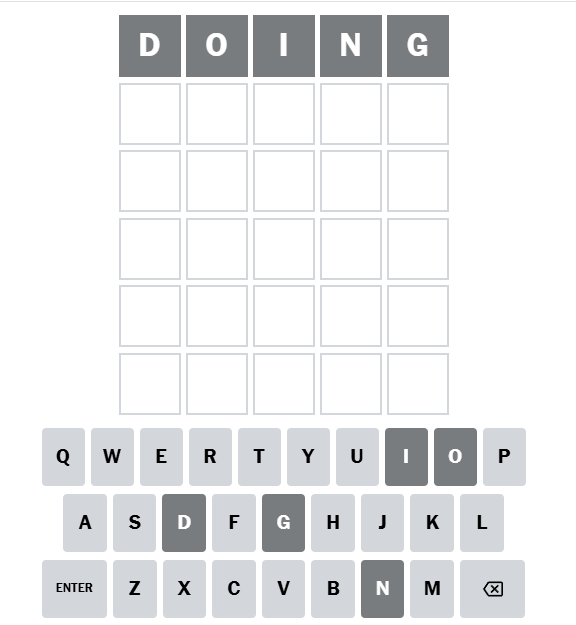

In [4]:
# Load test image
from IPython.display import Image, display

# Show the image
display(Image(filename='images/small_letters2.png'))

In [1]:
# Setup pytesseract
import pytesseract

config_file = r"tesseract_config/wordle.config"
conf_thresh = 0


def crop_cell_margin(crop):
    # Crop a little bit of the image to avoid the border setting off contour detection
    cell_boarder_margin = 0.1
    margin = int(cell_boarder_margin * min(crop.shape[:2]))
    crop = crop[margin:-margin, margin:-margin]
    return crop

def tesseract_inference(thresh):
    pred = pytesseract.image_to_data(
        thresh,
        lang="eng",
        config=f"{config_file}",
        output_type=pytesseract.Output.DICT
    )

    # If no index 5, means no letter was detected
    if 5 not in pred['level']:
        return None

    idx = pred['level'].index(5)
    letter = pred['text'][idx].strip().upper()
    confidence = int(pred['conf'][idx])

    return letter, confidence


def ocr_one_letter(crop):
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)

    MIN_CHAR_PX = 100
    h, w = crop.shape[:2]
    print(h,w)
    if h < MIN_CHAR_PX:
        print("Resized")
        gray = cv2.equalizeHist(gray)
        gray = cv2.resize(gray, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)

    _, thr = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    pred, conf = tesseract_inference(thr)

    print(pred)
    print(conf)

    return pred if conf > conf_thresh else None

def detect_letter(crop):

    area_frac_thresh = 0.02
    # Get height and width of the cell
    cell_area = crop.shape[0] * crop.shape[1]

    # Convert image to greyscale
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)

    # Adaptive thresholding, invert resulting image for morphological operations
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, blockSize=3, C=3)

    # Show the thresholded image
    cv2.imshow("Thresholded Image", thresh)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Find contours
    cnts, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Filter small cnt based on area and size
    min_area = cell_area * area_frac_thresh
    for cnt in cnts:
        if cv2.contourArea(cnt) >= min_area:
            return True

    return False

In [2]:
from image_processing import get_wordle_grid_boxes
import cv2

image = cv2.imread('images/small_letters.PNG')

rows = get_wordle_grid_boxes(image)

if rows:
    print(f"Extracted {len(rows)} rows from the Wordle board")

    # Crop the cells and put them into a nested list
    wordle_board = []
    for row in rows:
        wordle_board_row = []
        for cell in row:
            x, y, w, h = cell[1:5]
            cropped_cell = image[y:y+h, x:x+w]
            cropped_cell = crop_cell_margin(cropped_cell)
            wordle_board_row.append(cropped_cell)
        wordle_board.append(wordle_board_row)


    # Run Tesseract OCR on each cell
    for i, row in enumerate(wordle_board):
        for j, cell in enumerate(row):
            if detect_letter(cell.copy()):
                # Show the thresholded image
                cv2.imshow("Croped Image", cell)
                cv2.waitKey(0)
                cv2.destroyAllWindows()

                letter = ocr_one_letter(cell)
                print(f"Row {i+1}, Column {j+1}: {letter}")
            else:
                print(f"Row {i+1}, Column {j+1}: No letter detected")
else:
    print(f"Failed to extract wordle board, found {len(rows)} rows instead of 6")

Extracted 6 rows from the Wordle board
52 52
Resized
I
47
Row 1, Column 1: I
52 52
Resized
O
50
Row 1, Column 2: O
52 52
Resized
J
94
Row 1, Column 3: J
52 52
Resized
L
90
Row 1, Column 4: L
52 52
Resized
V
68
Row 1, Column 5: V
Row 2, Column 1: No letter detected
Row 2, Column 2: No letter detected
Row 2, Column 3: No letter detected
Row 2, Column 4: No letter detected
Row 2, Column 5: No letter detected
Row 3, Column 1: No letter detected
Row 3, Column 2: No letter detected
Row 3, Column 3: No letter detected
Row 3, Column 4: No letter detected
Row 3, Column 5: No letter detected
Row 4, Column 1: No letter detected
Row 4, Column 2: No letter detected
Row 4, Column 3: No letter detected
Row 4, Column 4: No letter detected
Row 4, Column 5: No letter detected
Row 5, Column 1: No letter detected
Row 5, Column 2: No letter detected
Row 5, Column 3: No letter detected
Row 5, Column 4: No letter detected
Row 5, Column 5: No letter detected
Row 6, Column 1: No letter detected
Row 6, Column 2